<a href="https://colab.research.google.com/github/arashsajjadi/Hyper-parameter-optimization/blob/main/Bbbp/Drafts/Raytune_based_sixth_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import ray
except:
    %pip install ray
    import ray


%pip install ray
try:
    import optuna
except:
    %pip install optuna
    import optuna


try:
    from torchmetrics import ConfusionMatrix
except:
    %pip install torchmetrics
    from torchmetrics import ConfusionMatrix

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,  TensorDataset, Dataset
import torch.nn.functional as F
from ray import tune
import os
import ray
from ray.tune.schedulers import ASHAScheduler
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
confmat = ConfusionMatrix(num_classes=2)

In [3]:
%%capture
try:
    from featurewiz import featurewiz
except:
    !pip install featurewiz==0.1.70
    from featurewiz import featurewiz

In [4]:
#read data
initial_targets=pd.read_csv("bbbp.csv")
initial_features=pd.read_csv("bbbp_global_cdf_rdkit.csv")

initial_features=initial_features.loc[:, (initial_features != initial_features.iloc[0]).any()] 

shuffled_targets=initial_targets.sample(frac=1,random_state=1234).reset_index(drop=True)
shuffled_features=initial_features.sample(frac=1,random_state=1234).reset_index(drop=True)
#shuffling the data to randomize the sequence

X_train, X_test, y_train, y_test = train_test_split(shuffled_features,shuffled_targets["p_np"],test_size=0.1, random_state=1234, stratify=shuffled_targets["p_np"])
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.22, random_state=1234, stratify=y_train)
X_train12 ,X_train34 , y_train12, y_train34=train_test_split(X_train,y_train,test_size=0.5, random_state=1234,stratify=y_train)
X_train1 ,X_train2 , y_train1, y_train2=train_test_split(X_train12,y_train12,test_size=0.5, random_state=1234,stratify=y_train12)
X_train3 ,X_train4 , y_train3, y_train4=train_test_split(X_train34,y_train34,test_size=0.5, random_state=1234,stratify=y_train34)
del X_train12
del X_train34
del y_train12
del y_train34
k_fold_X_train=[X_train1 ,X_train2,X_train3 ,X_train4 ]
k_fold_y_train=[y_train1 ,y_train2,y_train3 ,y_train4 ]
del X_train1
del X_train2
del X_train3
del X_train4
del y_train1
del y_train2
del y_train3
del y_train4

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
You supplied outputs = features
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (1431, 186)
    Loaded train data. Shape = (1431, 186)
    Some column names had special characters which were removed...
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#################

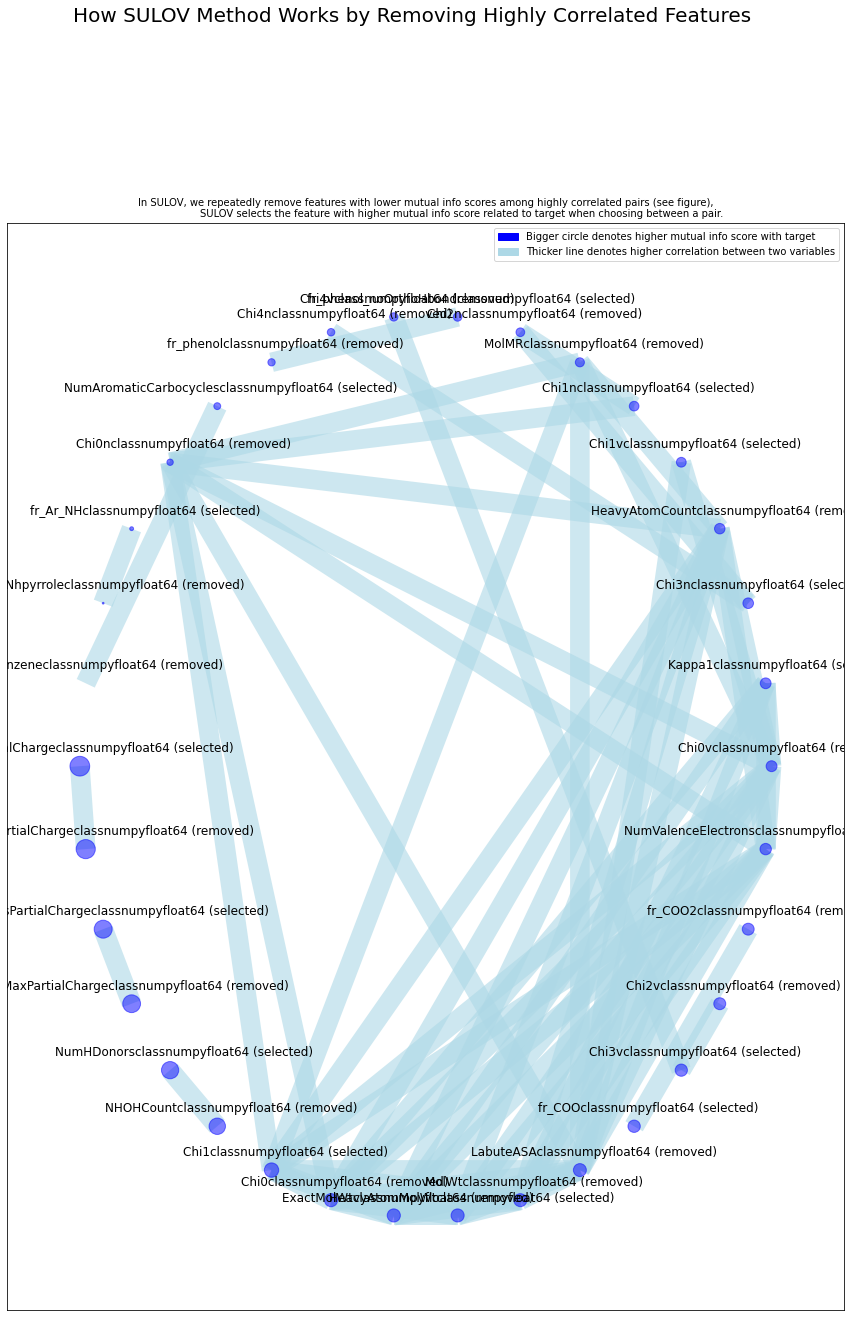

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 165
Final list of selected vars after SULOV = 165
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 165 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 165 variables...
            Time taken for regular XGBoost feature selection = 2 seconds
        using 132 variables...
            Time taken for regular XGBoost feature selection = 4 seconds
        using 99 variables...
            Time taken for regular XGBoost feature sele

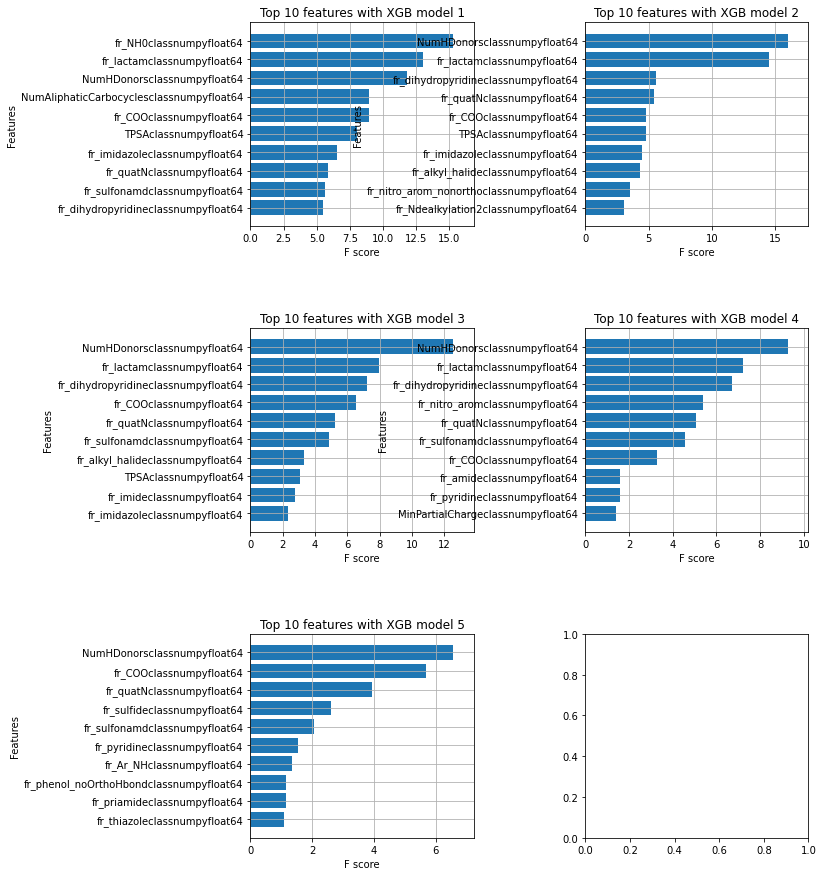

            Total time taken for XGBoost feature selection = 11 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 71 important features. Too many to print...

    Time taken for feature selection = 12 seconds
Returning 2 dataframes: dataname and test_data with 71 important features.


In [5]:
Data=pd.concat([X_train, y_train], axis=1) #reshape data for featurewiz feature selection
target = ['p_np']
from featurewiz import featurewiz 
feature_selection = featurewiz(Data, target, corr_limit=0.97, verbose=2,header=0, nrows=None,outputs="features")

X_train=X_train[feature_selection[0]]
X_valid=X_valid[feature_selection[0]]
X_test=X_test[feature_selection[0]]
y_train=pd.DataFrame(data=y_train)
y_valid=pd.DataFrame(data=y_valid)
y_test=pd.DataFrame(data=y_test)

for i in np.arange(0,4):
  k_fold_X_train[i]=k_fold_X_train[i][feature_selection[0]]
  k_fold_y_train[i]=pd.DataFrame(data=k_fold_y_train[i])

Apply feature selection result to sets

Define classes to load training, validation and test sets.

In [6]:
class BbbpDataset_train (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_train.to_numpy().astype("float32")
        self.y=y_train.to_numpy().astype("float32")
        self.n_samples=X_train.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class BbbpDataset_train (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_train.to_numpy().astype("float32")
        self.y=y_train.to_numpy().astype("float32")
        self.n_samples=X_train.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class kf_BbbpDataset_train (Dataset):
    def __init__(self,k,transform=None):
        #data loading np.delete(np.array([0,1,2,3]),k)
        self.x=(   k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])   ).to_numpy().astype("float32")
        self.y=(   k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])   ).to_numpy().astype("float32")
        self.n_samples=(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])).shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class kf_BbbpDataset_valid (Dataset):
    def __init__(self,k,transform=None):
        #data loading
        self.x=(k_fold_X_train[k]).to_numpy().astype("float32")
        self.y=(k_fold_y_train[k]).to_numpy().astype("float32")
        self.n_samples=(k_fold_X_train[k]).shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class BbbpDataset_valid (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_valid.to_numpy().astype("float32")
        self.y=y_valid.to_numpy().astype("float32")
        self.n_samples=X_valid.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class BbbpDataset_test (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_test.to_numpy().astype("float32")
        self.y=y_test.to_numpy().astype("float32")
        self.n_samples=X_test.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples
    
class ToTensor():
    def __call__(self,sample):
        inputs,targets=sample
        inputs=torch.from_numpy(inputs.astype("float32"))
        targets=torch.tensor(targets.astype("float32"))
        #targets=targets.view(targets.shape[0],1)
        return inputs,targets

#training set ---------------------------------------------------
training_set = BbbpDataset_train(transform=ToTensor())    
train_loader = DataLoader(dataset=training_set,
                          batch_size=64,
                          shuffle=True)

dataiter_train = iter(train_loader)
data_train = dataiter_train.next()


def trainloader(config):
    return  DataLoader(dataset=training_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
    
#kf-training set ---------------------------------------------------
def kf_trainloader(config,k):
    return  DataLoader(dataset=kf_BbbpDataset_train(k,transform=ToTensor())    ,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#kf-training set ---------------------------------------------------
def kf_validloader(config,k):
    return  DataLoader(dataset=kf_BbbpDataset_valid(k,transform=ToTensor())    ,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#validation set ---------------------------------------------------
validation_set = BbbpDataset_valid(transform=ToTensor())    
valid_loader = DataLoader(dataset=validation_set,
                          batch_size=64,
                          shuffle=True)

dataiter_valid = iter(valid_loader)
data_valid = dataiter_valid.next()

def validloader(config):
    return  DataLoader(dataset=validation_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#test set ---------------------------------------------------
test_set = BbbpDataset_test(transform=ToTensor())    
test_loader = DataLoader(dataset=test_set,
                          batch_size=8,
                          shuffle=False)

dataiter_test = iter(test_loader)
data_test = dataiter_test.next()

def testloader(config):
    return  DataLoader(dataset=test_set,
                          batch_size=4,
                          shuffle=False,num_workers=2)

Definition of roc_auc_score meter

In [7]:
from sklearn.metrics import roc_auc_score

def compute_score(model, data_loader, device="cpu"):
    model.eval()
    metric = roc_auc_score
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        for i, (feats, labels) in enumerate(data_loader):
            feats=feats.to(device)
            labels=labels.to(device)
            prediction = model(feats).to(device)
            prediction = torch.sigmoid(prediction).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)                
        try:
            t = metric(labels_all.int().cpu(), prediction_all.cpu()).item()
        except ValueError:
            t = 0
    return t

Definition of neural network

In [8]:
n_samples,n_features=X_train.shape
class NeuralNetwork (nn.Module):
    def __init__(self,n_input_features,l1, l2,l3,config):
        super (NeuralNetwork, self).__init__()
        self.config = config
        self.linear1=nn.Linear(n_input_features,4*math.floor(n_input_features/2)+l1)
        self.linear2=nn.Linear(l1+4*math.floor(n_input_features/2),math.floor(n_input_features/2)+l2)
        self.D1=torch.nn.Dropout(config.get("drop_out_ratio1"))
        self.linear3=nn.Linear(math.floor(n_input_features/2)+l2,math.floor(n_input_features/3)+l3)
        self.D2=torch.nn.Dropout(config.get("drop_out_ratio2"))
        self.linear5=nn.Linear(math.floor(n_input_features/3)+l3,1)

        self.a1 = self.config.get("a1")
        self.a2 = self.config.get("a2")
        self.a3 = self.config.get("a3")


    @staticmethod
    def activation_func(act_str):
        if act_str=="tanh" or act_str=="sigmoid":
            return eval("torch."+act_str)
        elif act_str=="silu" or act_str=="relu" or act_str=="leaky_relu" or act_str=="gelu":   
            return eval("torch.nn.functional."+act_str)

    def forward(self,x):
        out=self.linear1(x)
        out=self.activation_func(self.a1)(out.float())
        out=self.linear2(out)
        out=self.D1(out)
        out=self.activation_func(self.a2)(out.float())
        out=self.linear3(out)
        out=self.activation_func(self.a3)(out.float())
        out=self.D1(out)
        out=self.linear5(out)
        out=torch.sigmoid(out)
        y_predicted=out
        return y_predicted

Training loop

In [20]:
def train_Bbbp(config,checkpoint_dir=None,max_iter=11):
    net = NeuralNetwork(np.shape(feature_selection[0])[0],config["l1"],config["l2"],config["l3"],config)


    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #Define my loss function and optimizer
    criterion=nn.BCELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config["lr"])
    
    
    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored.
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
   

    localiter=0
    for epoch in range(max_iter):  # loop over the dataset multiple times
        running_loss1 = 0.0
        epoch_steps1 = 0
        for i, data in enumerate(kf_trainloader(config,1), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss1 += loss.item()
            epoch_steps1 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss1 / epoch_steps1))
                running_loss1 = 0.0


        # Validation score
        score1 = compute_score(net, kf_validloader(config,1), device="cpu")

    #second loop -----------------------------
   
        running_loss2 = 0.0
        epoch_steps2 = 0
        for i, data in enumerate(kf_trainloader(config,2), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss2 += loss.item()
            epoch_steps2 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss2 / epoch_steps2))
                running_loss2 = 0.0


        # Validation score
        
        score2 = compute_score(net, kf_validloader(config,2), device="cpu")
   
    #third loop -----------------------------
   
        running_loss3 = 0.0
        epoch_steps3 = 0
        for i, data in enumerate(kf_trainloader(config,3), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss3 += loss.item()
            epoch_steps3 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss3 / epoch_steps3))
                running_loss3 = 0.0


        # Validation score
        
        score3 = compute_score(net, kf_validloader(config,3), device="cpu")

    #forth loop -----------------------------
    for epoch in range(max_iter):  # loop over the dataset multiple times
        running_loss4 = 0.0
        epoch_steps4 = 0
        for i, data in enumerate(kf_trainloader(config,0), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss4 += loss.item()
            epoch_steps4 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss4 / epoch_steps4))
                running_loss4 = 0.0


        # Validation score
        
        score4 = compute_score(net, kf_validloader(config,0), device="cpu")
   
   

        # Validation score
        
        kf_score=np.min([score1,score2,score3,score4])
        #print(f"score1: {score1:.4f}, score2: {score2:.4f}, score3: {score3:.4f}. score4: {score4:.4f}--->kf_score: {kf_score:.5f}")

        localiter=localiter+1
        val_score = compute_score(net, validloader(config), device="cpu")

        score=np.mean([val_score,val_score,kf_score])-((localiter/max_iter)**2)*0.033-(kf_score-val_score)/5
        



        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(score=score,kf_score=kf_score,val_score=val_score)

    print("Finished Training")

Best model

In [10]:
def test_best_model(best_trial):
    best_trained_model = NeuralNetwork(np.shape(feature_selection[0])[0],best_trial.config["l1"],best_trial.config["l2"],best_trial.config["l3"],best_trial.config)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    test_score = compute_score(best_trained_model, testloader(best_trial.config), device)
    print("Best trial test set score:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {} ".format(test_score))
    return best_trial.config, best_trained_model

In [11]:
    config = {
      "l1": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "l2": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "l3": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.loguniform(1e-2, 1),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "a2":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "batch_size": tune.choice([ 16, 32, 64, 128]),   
      }

    config = {
      "l1": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "l2": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "l3": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.uniform(0.3, 0.6),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "a2":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu","silu","leaky_relu"]),
      "batch_size": tune.choice([ 32, 64, 128]),   
      }

    config = {
      "l1": tune.choice([2**6,2**7,2**8]),
      "l2": tune.choice([2**6,2**7,2**8]),
      "l3": tune.choice([2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.uniform(0.3, 0.6),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu","leaky_relu"]),
      "a2":tune.choice(["gelu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu"]),
      "batch_size": tune.choice([ 32, 64, 128]),   
      }

In [12]:
from ray.tune import CLIReporter
from functools import partial

In [13]:
def main(num_samples=10, max_num_epochs=100, gpus_per_trial=2):

    config = {
      "l1": tune.choice([2**6,2**7,2**8]),
      "l2": tune.choice([2**6,2**7,2**8]),
      "l3": tune.choice([2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.uniform(0.3, 0.6),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu","leaky_relu"]),
      "a2":tune.choice(["gelu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu"]),
      "batch_size": tune.choice([ 32, 64, 128]),   
      }

    from ray.tune.suggest.optuna import OptunaSearch 

    from ray.tune.suggest import ConcurrencyLimiter
    search_alg = OptunaSearch(
       metric="score", #or accuracy, etc.
       mode="max", #or max
       seed = 42,
       )
    search_alg = ConcurrencyLimiter(search_alg, max_concurrent=10)

    scheduler = ASHAScheduler(
        metric ="score",
        mode="max",
        max_t=max_num_epochs,
        reduction_factor=2, 
        grace_period=4,
        brackets=5
        )
    
    reporter = CLIReporter(
        metric_columns=["score","val_score","kf_score" ,"training_iteration"]
        )
    
    # wrap data loading and training for tuning using `partial` 
    # (note that there exist other methods for this purpose)
    max_iter=max_num_epochs
    result = tune.run(
        partial(train_Bbbp,max_iter=max_iter),
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=num_samples,
        config=config,
        verbose=3,
        checkpoint_score_attr="score",
        checkpoint_freq=0,
        keep_checkpoints_num=1,
        progress_reporter=reporter,
        resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
        stop={"training_iteration": max_iter},                
        )


    
    best_trial = result.get_best_trial("score", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Average ROC_AUC score of the chosen model for different validation sets in 4-fold cross validation: {}".format(best_trial.last_result["kf_score"]))
    print("Best trial final validation ROC_AUC:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {} ".format(best_trial.last_result["val_score"]))
    print("Best trial final score: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {}".format(best_trial.last_result["score"]))

    if ray.util.client.ray.is_connected():
        # If using Ray Client, we want to make sure checkpoint access
        # happens on the server. So we wrap `test_best_model` in a Ray task.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.util.ml_utils.node import force_on_current_node
        remote_fn = force_on_current_node(ray.remote(test_best_model))
        ray.get(remote_fn.remote(best_trial))
    else:
       best_trial.config, best_trained_model=test_best_model(best_trial)
    print("--------------------------------------------------")
    return best_trial.config, best_trained_model

configuration,Bneuralnetwork=main(num_samples=20, max_num_epochs=15, gpus_per_trial=0)

2022-07-17 19:32:01,143	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-07-17 19:32:01,152	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2022-07-17 19:32:01 (running for 00:00:00.76)
Memory usage on this node: 1.6/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/7.42 GiB heap, 0.0/3.71 GiB objects
Result logdir: /root/ray_results/train_Bbbp_2022-07-17_19-32-01
Number of trials: 1/20 (1 RUNNING)
+---------------------+----------+------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-----------+
| Trial name          | status   | loc              | a1   | a2         | a3   |   batch_size |   drop_out_ratio1 |   drop_out_ratio2 |   l1 |   l2 |   l3 |        lr |
|---------------------+----------+------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-----------|
| train_Bbbp_215e067e | RUNNING  | 172.28.0.2:99475 | relu | 

2022-07-17 19:38:19,709	INFO tune.py:748 -- Total run time: 378.84 seconds (378.29 seconds for the tuning loop).


Best trial config: {'l1': 64, 'l2': 128, 'l3': 128, 'lr': 0.0008162547177635398, 'drop_out_ratio1': 0.4130987912299135, 'drop_out_ratio2': 0.023279722531056955, 'a1': 'relu', 'a2': 'leaky_relu', 'a3': 'gelu', 'batch_size': 32}
Average ROC_AUC score of the chosen model for different validation sets in 4-fold cross validation: 0.9974925867783011
Best trial final validation ROC_AUC:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.8827797649463464 
Best trial final score: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.9124840388903314
Best trial test set score:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.905448717948718 
--------------------------------------------------


In [19]:
X_test_=torch.tensor(X_test.values).float()
X_train_=torch.tensor(X_train.values).float()
y_test_=torch.tensor(y_test.values).float()
X_valid_=torch.tensor(X_valid.values).float()
y_valid_=torch.tensor(y_valid.values).float()
y_train_=torch.tensor(y_train.values).float()
y_test_=y_test_.view(y_test.shape[0],1)
y_valid_=y_valid_.view(y_valid.shape[0],1)
y_train_=y_train_.view(y_train.shape[0],1)


with torch.no_grad():
  y_predicted=Bneuralnetwork(X_train_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_train_).sum()/float(y_train_.shape[0])
  a=confmat( y_predicted_cls.int(),y_train_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_train_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, trainloader(configuration), device="cpu")   :.19f}')
  print(a)

with torch.no_grad():
  y_predicted=Bneuralnetwork(X_valid_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_valid_).sum()/float(y_valid_.shape[0])
  a=confmat( y_predicted_cls.int(),y_valid_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_valid_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, validloader(configuration), device="cpu")   :.19f}')
  print(a)

with torch.no_grad():
  y_predicted=Bneuralnetwork(X_test_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_test_).sum()/float(y_test_.shape[0])
  a=confmat( y_predicted_cls.int(),y_test_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_test_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, testloader(configuration), device="cpu")   :.19f}')
  print(a)



accuracy=0.9839273095130920410     balanced_accuracy_score=0.9790651307044749840     ROC_AUC=0.9992104261796042053
tensor([[ 323,   13],
        [  10, 1085]])
accuracy=0.8465346693992614746     balanced_accuracy_score=0.7879436857072639189     ROC_AUC=0.8827797649463463570
tensor([[ 62,  33],
        [ 29, 280]])
accuracy=0.8872548937797546387     balanced_accuracy_score=0.8680207153261045860     ROC_AUC=0.9054487179487179516
tensor([[ 31,  17],
        [  6, 150]])


In [ ]:
#configuration2= {'l1': 128, 'l2': 256, 'l3': 32, 'lr': 0.0006406517930168021, 'a1': 'relu', 'a2': 'leaky_relu', 'a3': 'gelu', 'batch_size': 64, 'drop_out_ratio1': 0.424,'drop_out_ratio2': 0.019 }

In [21]:
def final_traing(config,max_iter=15):
    net = NeuralNetwork(np.shape(feature_selection[0])[0],config["l1"],config["l2"],config["l3"],config)


    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #Define my loss function and optimizer
    criterion=nn.BCELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config["lr"])

    for epoch in range(max_iter):
      running_loss = 0.0
      epoch_steps = 0
      for i, data in enumerate(trainloader(config), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
          print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
          running_loss = 0.0

        # Validation score
    score = compute_score(net, validloader(config), device="cpu")
    print(score)
    score = compute_score(net, testloader(config), device="cpu")
    print(score)
    print(config)
    return net

In [22]:
neurlnet=final_traing(configuration,max_iter=5)

0.9083120422415263
0.8824786324786325
{'l1': 64, 'l2': 128, 'l3': 128, 'lr': 0.0008162547177635398, 'drop_out_ratio1': 0.4130987912299135, 'drop_out_ratio2': 0.023279722531056955, 'a1': 'relu', 'a2': 'leaky_relu', 'a3': 'gelu', 'batch_size': 32}


In [23]:
with torch.no_grad():
    y_predicted=neurlnet(X_test_)
    y_predicted_cls=y_predicted.round()
    acc= y_predicted_cls.eq(y_test_).sum()/float(y_test_.shape[0])

    #print(f'accuracy={acc:.4f}')
    a=confmat( y_predicted_cls.int(),y_test_.int()) 
    print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_test_.int()):.19f}     ROC_AUC={compute_score(neurlnet, testloader(configuration), device="cpu")   :.19f}')
    print(a)

accuracy=0.8627451062202453613     balanced_accuracy_score=0.8352941176470587425     ROC_AUC=0.8824786324786324521
tensor([[ 27,  21],
        [  7, 149]])
